<a href="https://colab.research.google.com/github/verma-saloni/Thesis-Work/blob/main/09_26_22_networkx_graph_politifact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NB for visualising the politifact graph - how articles connect to tweets and if it is all connected, or disconnected. 

In [1]:
!pip -qq install jsonlines

In [2]:
from google.colab import drive
drive.mount('/gdrive')

from pathlib import Path
base_dir = Path("/gdrive/MyDrive/ResearchFND")
assert base_dir.exists()

Mounted at /gdrive


In [3]:
dataset_id = 'politifact'

In [4]:
import numpy as np
import pandas as pd
import ast
import json
import networkx as nx
import jsonlines

Using the networkx library since it is a simple visualisation tool. 
Souce: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx_nodes.html 


In [5]:
graph = nx.DiGraph()

Reading the followers and following files for politifact previously created, and saved in our drive for each DS. 

In [6]:
with jsonlines.open(base_dir/"followers.jsonl") as reader:
    for line in reader:
        v = line["user_id"]
        for u in line["followers"]:
            graph.add_edge(u, v)

In [7]:
with jsonlines.open(base_dir/"following.jsonl") as reader:
    for line in reader:
        u = line["user_id"]
        for v in line["following"]:
            graph.add_edge(u, v)

In [8]:
df = pd.read_csv(base_dir/f'{dataset_id}_agg.csv')
df.head(2)

,title,text,tweets,retweets,label,url,tweet_ids,num_retweets,log_num_retweets,num_tweets,log_num_tweets
0,Actress Emma Stone ‘For the first time in his...,NaN,[],"['1020554564334964741', '1020817527046197248',...",fake,NaN,[],2911,7.976595,0,0.0
1,Breaking President Trump makes English the of...,NaN,[],[],fake,NaN,[],0,0.000000,0,0.0


In [9]:
df['tweets'] = df.tweets.map(ast.literal_eval)

In [10]:
# Mapping each userId to the tweets in our DS.
users_tweeted = df.tweets.map(lambda x: [int(e['user_id']) for e in x])

In [11]:
len(users_tweeted), sum(users_tweeted.map(len) > 0)

(894, 149)

In [12]:
follow_src = []
follow_dst = []
with jsonlines.open(base_dir/"followers.jsonl") as reader:
    for line in reader:
        v = line["user_id"]
        for u in line["followers"]:
            follow_src.append(u)
            follow_dst.append(v)

In [13]:
with jsonlines.open(base_dir/"following.jsonl") as reader:
    for line in reader:
        u = line["user_id"]
        for v in line["following"]:
            follow_src.append(u)
            follow_dst.append(v)

In [14]:
with open(base_dir/'t2u.json') as f:
    t2u = json.load(f)

with open(base_dir/'users_info.json') as f:
    users_info = json.load(f)

In [15]:
for u, info in users_info.items():
    for v in info['followers']:
        break
        follow_src.append(v)
        follow_dst.append(int(u))
    for v in info['friends']:
        follow_src.append(int(u))
        follow_dst.append(v)

In [16]:
tweet_src = []
tweet_dst = []

for v, l in users_tweeted.iteritems():
    if not len(l):
        continue
    for u in l:
        tweet_src.append(u)
        tweet_dst.append(v)

In [17]:
users_retweeted = df.retweets.map(lambda x: [t2u[str(e)] for e in x if (str(e) in t2u)])

In [18]:
for v, l in users_retweeted.iteritems():
    if not len(l):
        continue
    for u in l:    
        tweet_src.append(u)
        tweet_dst.append(v)

In [19]:
with open(base_dir/f'{dataset_id}_edges.txt', 'w') as f:
    for src, dst in zip(follow_src, follow_dst):
        f.write(f"{src}\t{dst}\tfollows\n")
    for src, dst in zip(tweet_src, tweet_dst):
        f.write(f"{src}\t{dst}\ttwitted\n")

In [20]:
user_nodes = set(follow_src)
user_nodes.update(follow_dst)
user_nodes.update(tweet_src)

graph.add_nodes_from(list(user_nodes), kind='user')

In [21]:
graph.add_nodes_from(tweet_dst, kind='article')

In [22]:
graph.add_edges_from([(u,v) for u,v in zip(follow_src, follow_dst)], relation='follows')
graph.add_edges_from([(u,v) for u,v in zip(tweet_src, tweet_dst)], relation='tweets')

In [23]:
graph.number_of_nodes(), graph.number_of_edges()

(120980, 150696)

In [24]:
followed = [n for n in graph.nodes if graph.in_degree(n)>2]
len(followed)

1371

In [25]:
nx.number_weakly_connected_components(graph)

10

In [26]:
nx.density(graph)

1.0296228076160784e-05

In [27]:
import random

sample_nodes = random.sample(tweet_dst, 5)
sg = graph.edge_subgraph(graph.in_edges(sample_nodes))
sg.number_of_nodes(), sg.number_of_edges()

(13812, 13822)

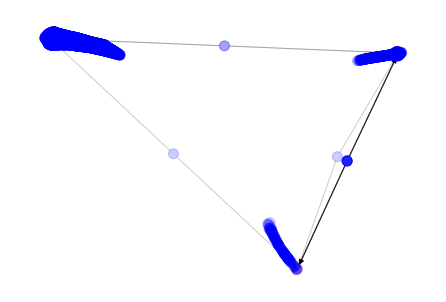

In [28]:
# The alpha value will control transparency, not color.

colors = ['red' if d['kind']=='article' else 'blue' for n,d in sg.nodes(data=True)]
nx.draw(sg, node_size=100, node_color=colors, alpha=0.2)

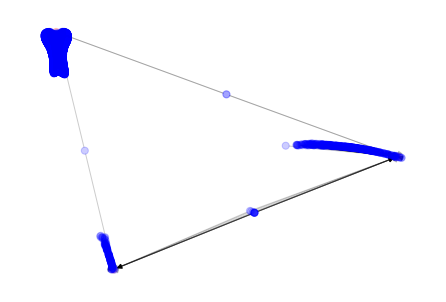

In [29]:
nx.draw(sg, node_size=50, node_color=colors, alpha=0.2)

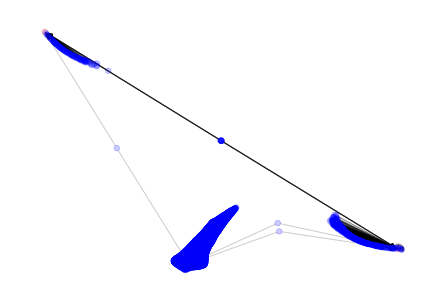

In [30]:
nx.draw(sg, node_size=30, node_color=colors, alpha=0.2)

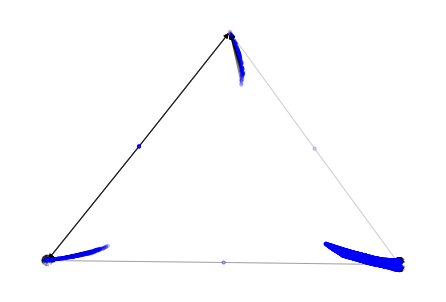

In [31]:
nx.draw(sg, node_size=10, node_color=colors, alpha=0.2)